# K-fold Croos Validation for CNN model using TensorFlow

### Import the necessary libraries

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import mlflow
import mlflow.keras
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D

### Load the Dataset

In [4]:
df = pd.read_csv('randomized_balanced.csv')
df.head()

,review,label
0,Seems more transparent & meaningful issues.,rating
1,The best app for editing texts,rating
2,It seems like it would be a great addition to ...,feature request
3,Its really fun and any age can play it and enj...,user experience
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report


## Start of Preprocessing

In [5]:
df['count'] = df['review'].apply(lambda x: len(x.split())) # add a column for the number of words in the review
df.head()

,review,label,count
0,Seems more transparent & meaningful issues.,rating,6
1,The best app for editing texts,rating,6
2,It seems like it would be a great addition to ...,feature request,27
3,Its really fun and any age can play it and enj...,user experience,20
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43


### Get the number of word distrubution in the dataset

<Figure size 800x800 with 0 Axes>

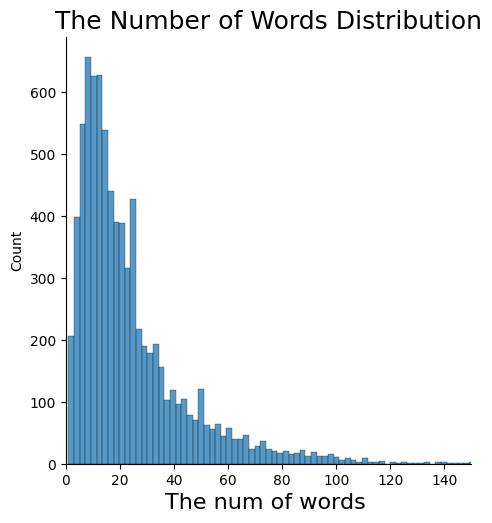

In [6]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 150)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

### Assign a Unique Integer for each target Class

In [7]:
df['encoded_text'] = df['label'].astype('category').cat.codes # encode the class labels

df.head(10)

,review,label,count,encoded_text
0,Seems more transparent & meaningful issues.,rating,6,2
1,The best app for editing texts,rating,6,2
2,It seems like it would be a great addition to ...,feature request,27,1
3,Its really fun and any age can play it and enj...,user experience,20,3
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43,0
5,Good app really really Best app Thanks Faceboo...,rating,9,2
6,I think we should get more.,feature request,6,1
7,No option for dark mode on my Motorola g5 stylus,feature request,10,1
8,atomic_number_53 gave it a 4 star because I co...,bug report,19,0
9,"Not what it use to be, too many ads. Not enoug...",user experience,47,3


In [8]:
data_texts = df['review'] 
data_labels = df['encoded_text']

## K-Fold Cross Validation for CNN Model

In [10]:
# Initialize the k-fold and the number of folds
kf = KFold(n_splits=5, shuffle=False, random_state=None)

# The main loop
for fold, (train_index, val_index) in enumerate(kf.split(data_texts), 1): # Start counting fold from 1
    print(f"Fold {fold}") # Print the fold number for clarity

    train_texts, val_texts = data_texts[train_index], data_texts[val_index] # Split the data into training and validation
    train_labels, val_labels = data_labels[train_index], data_labels[val_index] # Split the labels into training and validation

    # Initialize the tokenizer with a 10000 word limit
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(train_texts)

    # Tokenize and pad the training and validation data
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    train_padded = pad_sequences(train_sequences, maxlen=128, padding='post')
    val_padded = pad_sequences(val_sequences, maxlen=128, padding='post')
    

    # Get the best model from the MLflow server
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=100, input_length=128))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Compile the model with the best parameters
    model.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), batch_size=8) # Train the model 

    # Use the trained model to make predictions on the validation data and calculate the scores
    val_pred = np.argmax(model.predict(val_padded), axis=1)
    accuracy = accuracy_score(val_labels, val_pred)
    precision = precision_score(val_labels, val_pred, average=None)
    recall = recall_score(val_labels, val_pred, average=None)
    f1 = f1_score(val_labels, val_pred, average=None)

    # Print the scores for the each fold
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy}, - Precision: {precision}, - Recall: {recall}, - F1 Score: {f1}")



Fold 1
Epoch 1/5
800/800 [==============================] - 4s 4ms/step - loss: 0.9588 - accuracy: 0.6159 - val_loss: 0.6171 - val_accuracy: 0.7713
Epoch 2/5
800/800 [==============================] - 5s 6ms/step - loss: 0.3824 - accuracy: 0.8723 - val_loss: 0.3774 - val_accuracy: 0.8712
Epoch 3/5
800/800 [==============================] - 11s 14ms/step - loss: 0.1525 - accuracy: 0.9563 - val_loss: 0.2899 - val_accuracy: 0.9038
Epoch 4/5
800/800 [==============================] - 12s 15ms/step - loss: 0.0760 - accuracy: 0.9809 - val_loss: 0.2663 - val_accuracy: 0.9194
Epoch 5/5
50/50 [==============================] - 1s 8ms/step
Fold 1
Accuracy: 0.9225, - Precision: [0.94132653 0.94258373 0.91563275 0.88888889], - Recall: [0.91563275 0.92488263 0.9225     0.92722372], - F1 Score: [0.92830189 0.93364929 0.91905355 0.90765172]
Fold 2
Epoch 1/5
800/800 [==============================] - 12s 13ms/step - loss: 0.9387 - accuracy: 0.6272 - val_loss: 0.6404 - val_accuracy: 0.7606
Epoch 2/5
80